# Preambule

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import javabridge
import bioformats as bf
javabridge.start_vm(class_path=bf.JARS)
from collections import OrderedDict
import pandas as pd
from scipy.stats import distributions as dst
import numpy as np

In [4]:
%config Completer.use_jedi = False

In [5]:
from matplotlib.patches import Rectangle

In [6]:
omeTag = "http://www.openmicroscopy.org/Schemas/OME/2016-06"

def printRecur(root, maxLevel=np.inf, stoppingCrit=None):
    """Recursively prints the tree."""
    global level
    try: Levels[level] += 1
    except: pass
    if stoppingCrit is not None:
        if stoppingCrit(Levels):
            return None
    title = root.tag.title().lower().replace(omeTag.lower(),"").replace("{}","")
    txt = root.text
    if txt is None: txt = ""
    else: txt =  ": "+txt
    count = ".".join(Levels.astype(int).astype(str))#.rstrip(".0")
    isplit = count.find(".0")
    if isplit>0:
        count = count[:isplit]
    count += (10-len(count))*" "
    print (count, end="")
    print (' '*4*level,title,txt)
    level += 1
    if level<=maxLevel:
        for elem in root:
            printRecur(elem, maxLevel=maxLevel,stoppingCrit=stoppingCrit)
    level -= 1
    Levels[level+1:] = 0

In [7]:
from sys import path as syspath
from os.path import expanduser
syspath.append(expanduser("~/Seafile/functions/"))
from general_functions import autocorr, tally

In [8]:
from general_functions import moving_average

## Parse metadata

In [9]:
filename = "Experiment1.lif"

In [10]:
md = bf.get_omexml_metadata("./data/"+filename)

xml = bf.OMEXML(md)
Nimages = xml.get_image_count()
mdf = []
for i in range(Nimages):
    im = xml.image(index=i)
    tmp = OrderedDict([(attrib,getattr(im,attrib)) for attrib in ["Name","AcquisitionDate"]])
    for dim in "XYTCZ":
        tmp[dim] = getattr(im.Pixels, "Size"+dim)
    mdf += [tmp]

mdf = pd.DataFrame(mdf)

In [11]:
try:
    mdf["AcquisitionDate"] = pd.to_datetime(mdf["AcquisitionDate"])
except:
    pass

In [229]:
for child in root:
    break

In [231]:
child.tag

'{http://www.openmicroscopy.org/Schemas/OME/2016-06}Instrument'

In [226]:
root.findall("ExposureTime")

[]

In [ ]:
ExposureTime

In [12]:
mdf#.loc[:,["X","Y","T","inferedTimes"]]

,Name,AcquisitionDate,X,Y,T,C,Z
0,Image019,2019-07-01 14:02:42,1024,1024,1,1,1
1,Image022,2019-07-01 14:04:07,1024,1024,1,1,1
2,Series023,2019-07-01 14:04:44,512,512,1,1,1
3,Series024,2019-07-01 14:05:01,512,512,252,1,1
4,Series028,2019-07-01 14:10:44,64,64,13490,1,1
5,Series029,2019-07-01 14:14:10,512,512,415,1,1
6,Series030,2019-07-01 14:21:30,64,64,6478,1,1
7,Series032,2019-07-01 14:23:45,64,64,16644,1,1
8,Series033,2019-07-01 14:28:39,512,512,45,1,1
9,Series034,2019-07-01 14:29:20,512,512,756,1,1


In [13]:
rdr = bf.ImageReader("./data/"+filename, perform_init=True)

# Parse Annotations

In [14]:
import xml.etree.ElementTree as ET

In [15]:
realXML = xml.to_xml()

In [16]:
with open("tmp.xml","w") as f:
    f.write(realXML)
tree = ET.ElementTree(file="tmp.xml")
root = tree.getroot()

In [17]:
annotations = root[-1]

In [19]:
allFeatures = np.unique([" ".join(elem.text.split()[1:]) for elem in annotations.iter("{%s}"%omeTag+"Key")])

In [20]:
len(allFeatures)

194

In [21]:
%%time
features = pd.DataFrame(index=mdf.Name,columns=allFeatures)

for elem in annotations.iter("{%s}"%omeTag + "OriginalMetadata"):
    keys   = elem.findall(   "{%s}"%omeTag + "Key")
    values = elem.findall(   "{%s}"%omeTag + "Value")
    assert len(keys)==len(values)
    for k,v in zip(keys,values):
        name = k.text.split()[0]
        feature = " ".join(k.text.split()[1:])
        features.loc[name, feature] = v.text

CPU times: user 1.55 s, sys: 10 ms, total: 1.56 s
Wall time: 1.56 s


In [22]:
len(features.columns)

194

In [23]:
for ft in allFeatures:
    try:
        features[ft] = pd.to_numeric(features[ft], downcast="float")
    except:
        continue
        
    try:
        v = features[ft]
        vint = pd.to_numeric(v, downcast="integer")
        if np.sum((vint-v)**2)==0:
            features[ft] = vint
    except:
        continue

In [24]:
constFeatures = OrderedDict([(ft,features[ft].values[0]) for ft in allFeatures if len(features[ft].unique())==1])

In [25]:
# assert all numerical constanct values do NOT have NANs
assert np.all([np.isfinite(features[ft].values) for ft in constFeatures if type(constFeatures[ft])!=str])

In [26]:
varFeatures = [ft for ft in allFeatures if ft not in constFeatures]

In [27]:
features = features[varFeatures]

In [28]:
len(features.columns)

21

In [29]:
# import pandas_profiling as pp
# pp.ProfileReport(features)

In [30]:
nameAlias = OrderedDict([(ft,ft.split("|")[-1].replace(" ","_").replace("#","")) for ft in varFeatures])

In [31]:
lineAvg = features.rename(columns=nameAlias)['nAverageLine_1']
# .idxsort()

In [40]:
mdf = mdf.join(lineAvg,on="Name")

In [42]:
mdf.sort_values("nAverageLine_1")

,Name,AcquisitionDate,X,Y,T,C,Z,nAverageLine_1
11,Series036,2019-07-01 14:40:07,64,64,17155,1,1,2
22,Series051,2019-07-01 15:04:33,64,64,13256,1,1,2
10,Series035,2019-07-01 14:36:16,64,64,14133,1,1,2
7,Series032,2019-07-01 14:23:45,64,64,16644,1,1,2
6,Series030,2019-07-01 14:21:30,64,64,6478,1,1,2
23,Series052,2019-07-01 15:08:38,64,64,3115,1,1,2
4,Series028,2019-07-01 14:10:44,64,64,13490,1,1,2
18,Series046,2019-07-01 15:00:02,512,512,316,1,1,16
17,Series044,2019-07-01 14:53:24,512,512,387,1,1,16
15,Series041,2019-07-01 14:51:23,512,512,33,1,1,16


In [46]:
# ixSort = lineAvg.sort_values().index

In [47]:
# Choose the rank order (in terms of line average) of the image/series
# ix = ixSort[2]

In [48]:
# features.rename(columns=nameAlias).loc[ix]

In [177]:
idx = 4#np.where(features.index==ix)[0][0]
Name = mdf.loc[idx,"Name"]
dimensions = mdf.loc[idx,list("XYZCT")]
image = np.array([
            rdr.read(series=idx, rescale=False,t=t, ) for t in range(dimensions["T"])
        ])

In [178]:
image.shape

(13490, 64, 64)

In [179]:
# ims = image[::300]
# ims.shape

In [180]:
Nsample = int(1e7)
pixelSample = np.random.choice(image.flatten(), Nsample)

In [181]:
x,y = np.array(tally(pixelSample)).T

In [182]:
xth = 125
yth = 3e4

<BarContainer object of 47 artists>

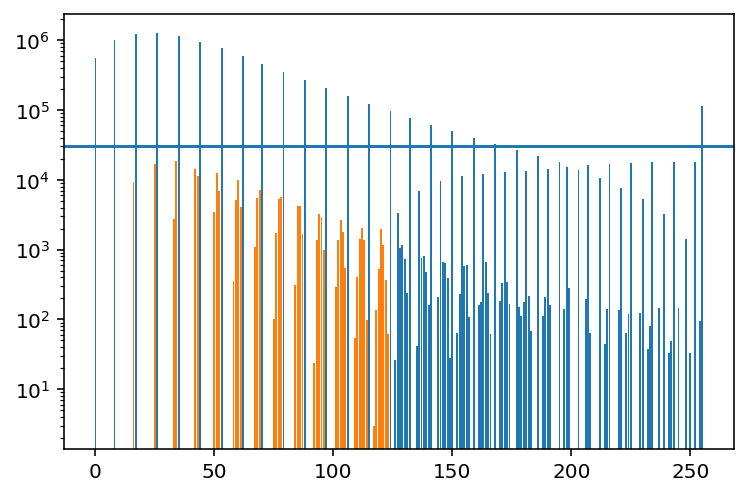

In [68]:
plt.bar(x,y)
plt.yscale("log")
plt.axhline(yth)
take = x[y<yth]
take = take[take<xth]

tmp = pixelSample
tmp = tmp[np.isin(tmp,take)]
x_noise,y_noise = np.array(tally(tmp)).T
plt.bar(x_noise,y_noise)

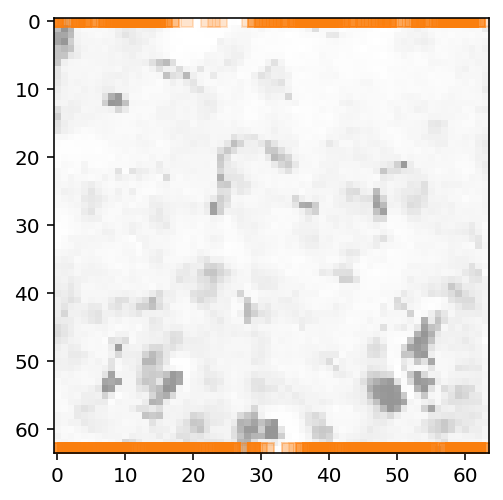

In [69]:
plt.figure(figsize=(4,4))
ims = image[::1000]
plt.imshow(np.mean(ims,axis=0).T, cmap="Greys",vmax=2*256)
for t,x,y in zip(*np.where(np.isin(ims,take))):
    plt.plot(x,y,"C1s",
             alpha = .2
            )
    #, mfc="none")#,mec="C1")

In [70]:
Nsample = int(1e7)
pixelSampleRed = np.random.choice(image.T[1:-1].flatten(), Nsample)
xRed,yRed = np.array(tally(pixelSampleRed)).T

In [71]:
tmp = xRed[yRed>yth]
tmp = tmp[tmp<xth]
meanDiff = np.diff(tmp).mean()

In [72]:
meanDiff

8.857142857142858

In [73]:
collectBulk = [xRed[0]]
for el in xRed[1:-1]:
    if np.abs(el-collectBulk[-1]-meanDiff)<1.5:
        collectBulk += [el]

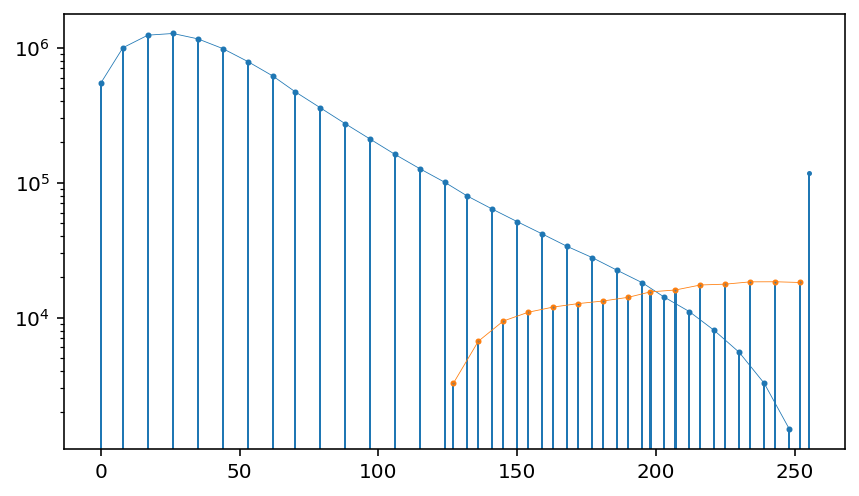

In [74]:
plt.figure(figsize=(7,4))
plt.bar(xRed,yRed,color="C0")
plt.plot(xRed,yRed,".-", ms=3, lw=0,color="C0")
plt.yscale("log")

fltr = np.isin(xRed, collectBulk)
for xf,yf in [
    (xRed[ fltr], yRed[ fltr]),
    (xRed[~fltr], yRed[~fltr]),
]:
    ff = xf!=xRed.max()
    xf = xf[ff]
    yf = yf[ff]
    plt.plot(xf,yf,".-", ms=4, lw=.4, mfc="none")

In [219]:
[(k,v) for k,v in constFeatures.items() if type(v) is str and "Standard" in v]

[('HardwareSetting|FilterSettingRecord|HyD 1 (AcquisitionMode) #1',
  'Standard')]

In [75]:
scale = np.diff(xRed[fltr]).mean()

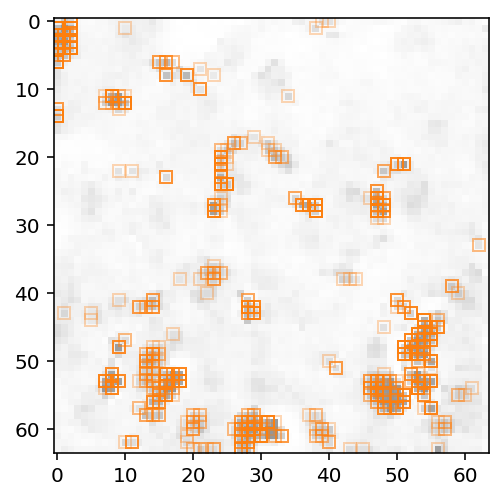

In [76]:
plt.figure(figsize=(4,4))
ims = image[::1000]
plt.imshow(np.mean(ims,axis=0).T, cmap="Greys",vmax=2*256)
for t,x,y in zip(*np.where(np.isin(ims,xf))):
    plt.plot(x,y,"C1s",
             alpha = .3,
             mfc="none"
            )
    #, mfc="none")#,mec="C1")

In [77]:
# xl = plt.xlim()
# realxx = dst.expon.rvs(scale=3.6,size=(2,Nsample//2))
# xx = (realxx.flatten().astype( int)*8.865).astype(int)
# xr, yr = np.array(tally(xx)).T
# plt.plot(xr, yr, ".-", mfc="none", ms=5, lw=.5)

# plt.xlim(xl)

In [79]:
timeStd = np.std(image, axis=0)

In [90]:
RFs = [    
    (np.arange(44,49),
     np.arange(2,8)),
    
    (np.arange(0,6),
     np.arange(18,21)),
    
    (np.arange(9,16),
     np.arange(48,60)),
]

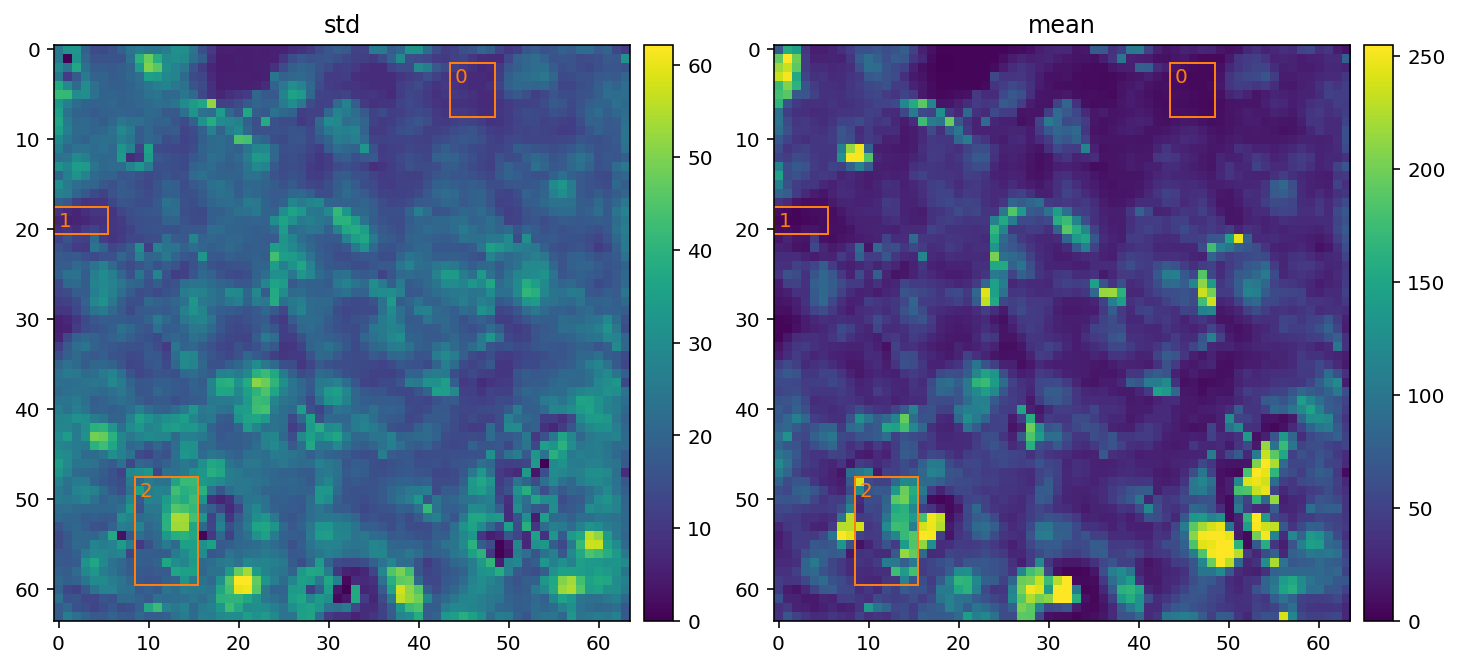

In [91]:
fig = plt.figure(figsize=(10,4))
axs = [
    fig.add_axes([ 0,0,.4,1]),
    fig.add_axes([.5,0,.4,1]),
]
caxs = [
    fig.add_axes([.41,0,.02,1]),
    fig.add_axes([.91,0,.02,1]),
]
for X,ax,cax,name in zip([timeStd,np.mean(image,axis=0)],axs,caxs,["std","mean"]):
    im_ = ax.imshow(X.T, vmin=0)
    plt.colorbar(im_, cax=cax)
    ax.set_title(name)
    ir = 0
    for regionFilter in RFs:
        roi = Rectangle(
            (regionFilter[0].min()-.5,regionFilter[1].min()-.5),
            width=len(regionFilter[0]),
            height=len(regionFilter[1]),
            fill=False,
            edgecolor="C1"
        )
        ax.add_patch(roi)
        ax.text(regionFilter[0].min(),regionFilter[1].min(),ir,color="C1",va="top")
        ir+=1


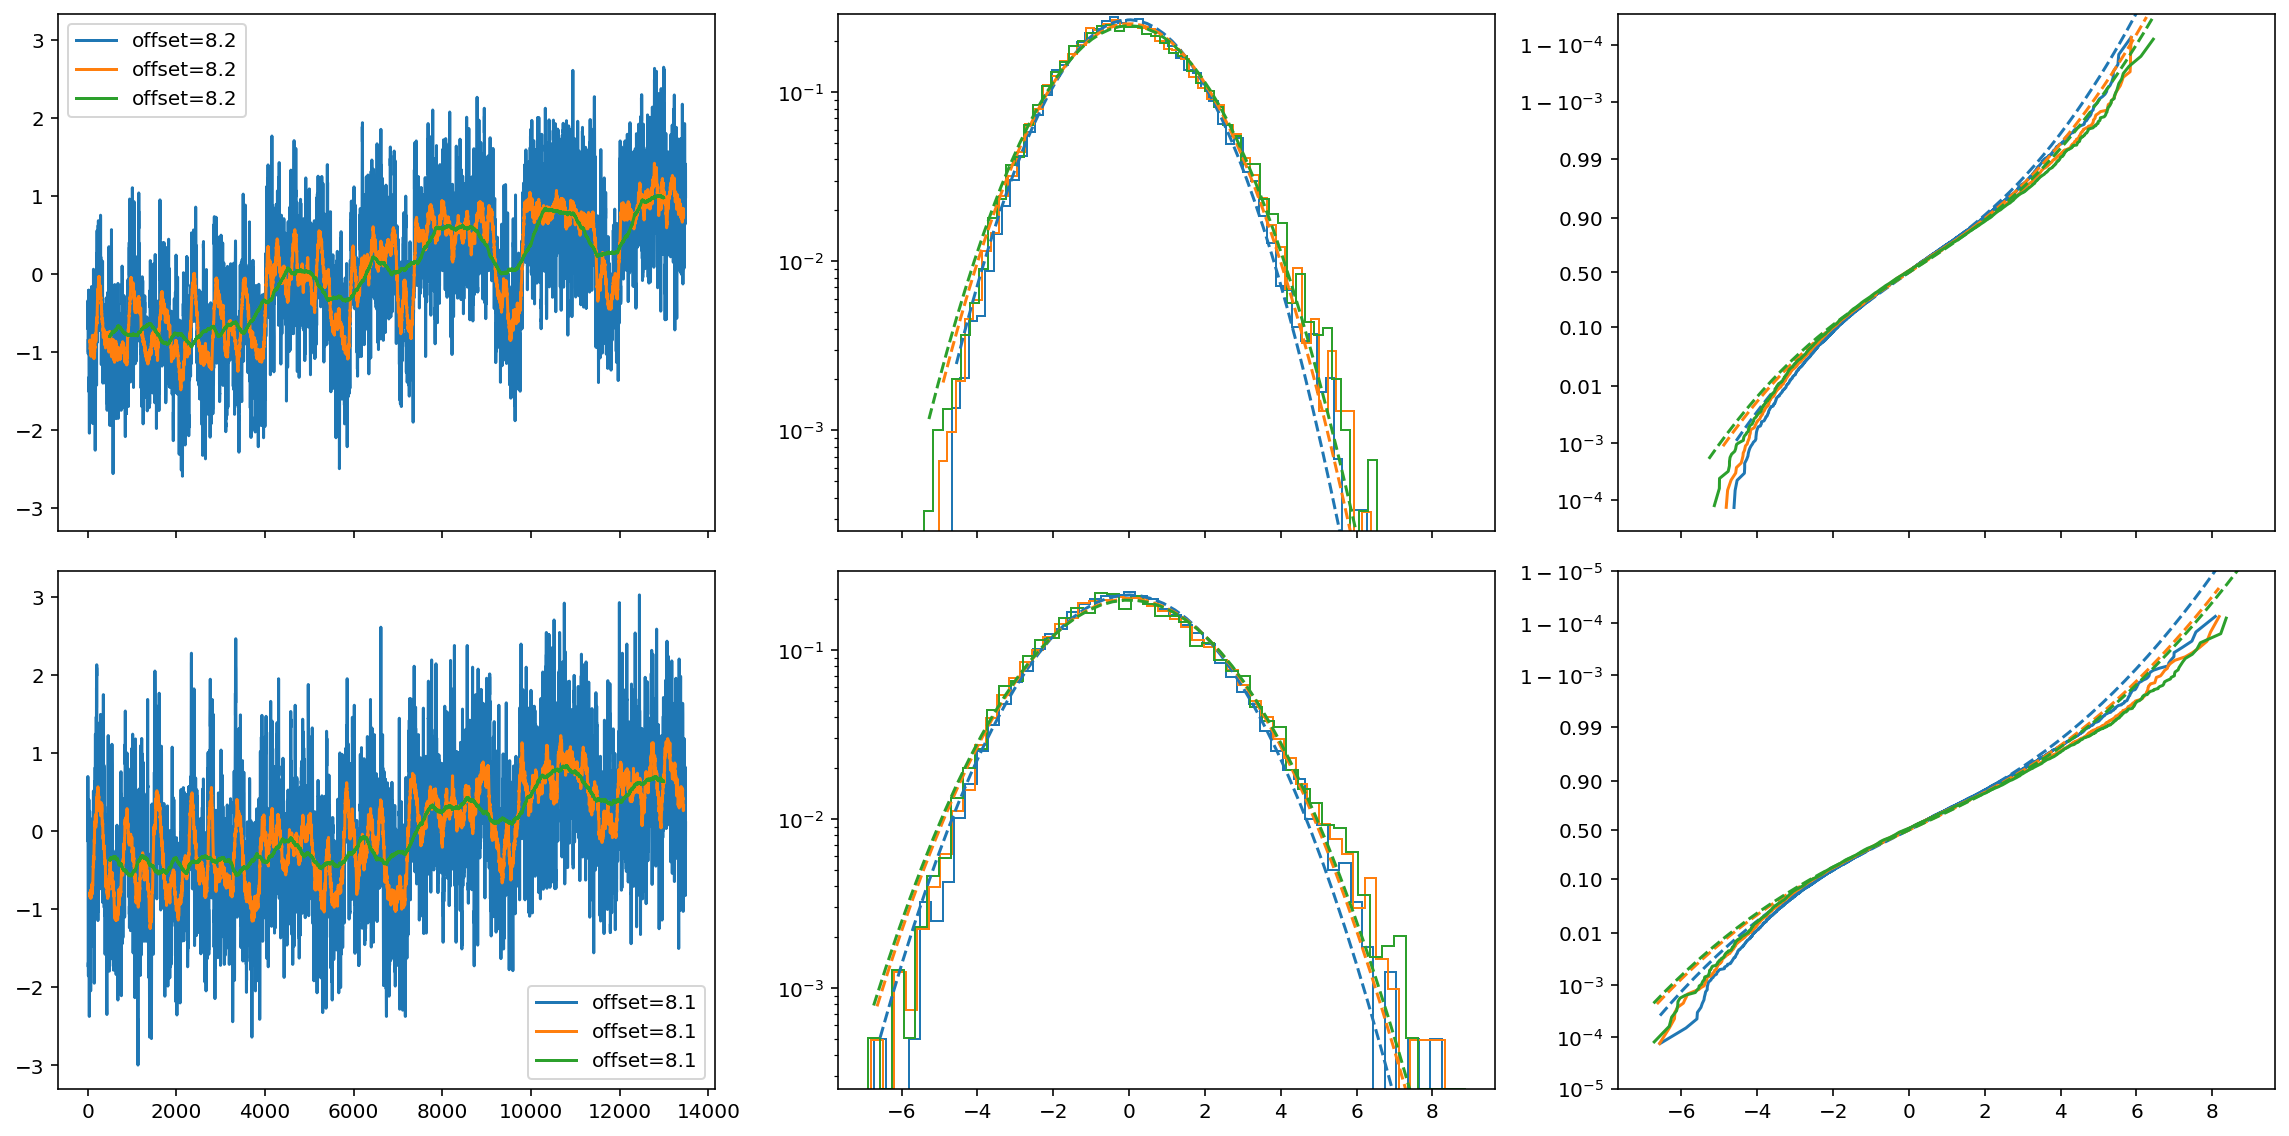

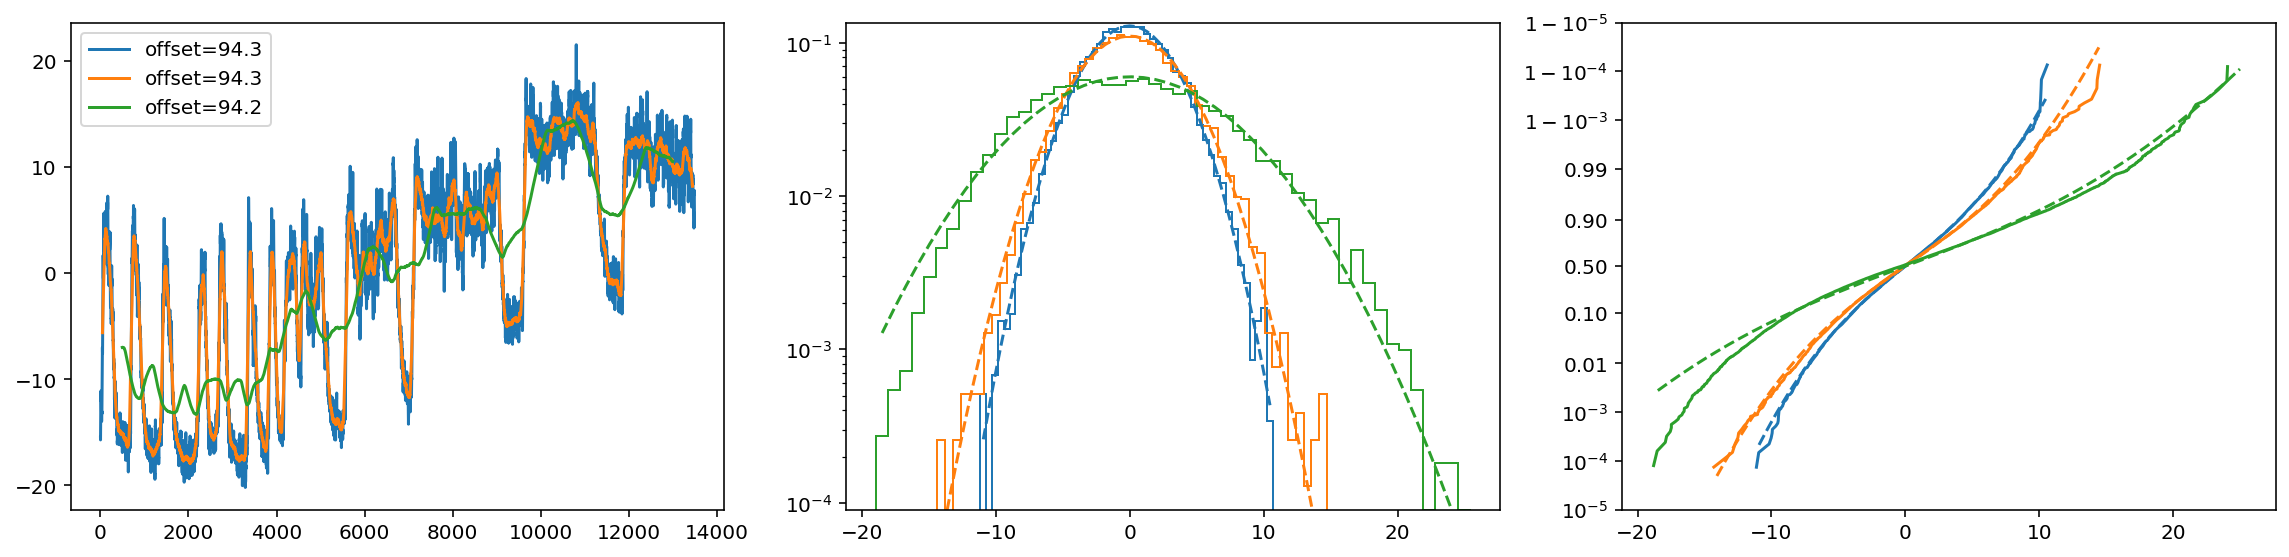

In [184]:
for showRFs in [RFs[:-1],RFs[-1:]]:
    fig, Axs = plt.subplots(len(showRFs),3,figsize=(16,4*len(showRFs)), sharex="col", sharey="col")
    if len(Axs.shape)==1:
        Axs=Axs.reshape(1,-1)

    for ir,regionFilter in enumerate(showRFs):
        axs = Axs[ir]
        timeProfile = np.mean(image.T[np.ix_(*regionFilter[::-1])].T, axis=(1,2))
        profileAverages = OrderedDict()
        for dtAvg in [10,100,1000]:
            dtAvg -= 1
            timeProfileAvg = moving_average(timeProfile,dtAvg)
            timeAvg = moving_average(np.arange(len(timeProfile)), dtAvg)
            rest = timeProfile[dtAvg//2:-(dtAvg//2)]-timeProfileAvg
            profileAverages[dtAvg+1] = pd.DataFrame(OrderedDict([
                ("time", timeAvg),
                ("smooth", timeProfileAvg),
                ("rest", rest),
            ]))
            c = axs[0].plot(timeAvg,timeProfileAvg-timeProfileAvg.mean(),label="offset=%.1f"%timeProfileAvg.mean())[0].get_color()
            yb,bbs,_ = axs[1].hist(rest,50,histtype="step",density=True)
            xb = (bbs[:-1]+bbs[1:])/2
            restStd = rest.std()
            axs[1].plot(xb,dst.norm.pdf(xb,scale=restStd),c=c,ls="--")
            x = rest.copy()
            axs[1].set_ylim(yb[yb>0].min(),)
            axs[2].plot(sorted(x),np.linspace(0,1,len(x)))
            axs[2].plot(xb,dst.norm.cdf(xb,scale=restStd),c=c,ls="--")
        axs[0].legend()
        axs[1].set_yscale("log")
        axs[2].set_yscale("logit")
        axs[2].set_yticks(axs[2].get_yticks())
        yx = axs[2].yaxis
        l = yx.get_minor_locator()
        l.minor = False
    #     break
    fig.tight_layout()

In [220]:
mdf.loc[idx]

Name                         Series028
AcquisitionDate    2019-07-01 14:10:44
X                                   64
Y                                   64
T                                13490
C                                    1
Z                                    1
nAverageLine_1                       2
Name: 4, dtype: object

In [222]:
filename

'Experiment1.lif'

In [221]:
13500/177.244

76.16618898241971

In [213]:
features.loc[Name]

DimensionDescription|BytesInc                                         4096
DimensionDescription|DimID                                               4
DimensionDescription|Length                                        177.244
DimensionDescription|NumberOfElements                                13490
DimensionDescription|Origin                                              0
DimensionDescription|Unit                                                s
HardwareSetting|FilterSettingRecord|AOTF (488) #1                  33.9987
HardwareSetting|FilterSettingRecord|DMI6000 Stage Pos x #1       0.0185214
HardwareSetting|FilterSettingRecord|DMI6000 Stage Pos y #1       0.0140453
HardwareSetting|ScannerSettingRecord|dblSizeZ #1                   175.357
HardwareSetting|ScannerSettingRecord|dblVoxelX #1              2.29721e-06
HardwareSetting|ScannerSettingRecord|dblVoxelY #1              2.29721e-06
HardwareSetting|ScannerSettingRecord|dblZWidePos #1             0.00500704
HardwareSetting|ScannerSe

<IPython.core.display.Javascript object>


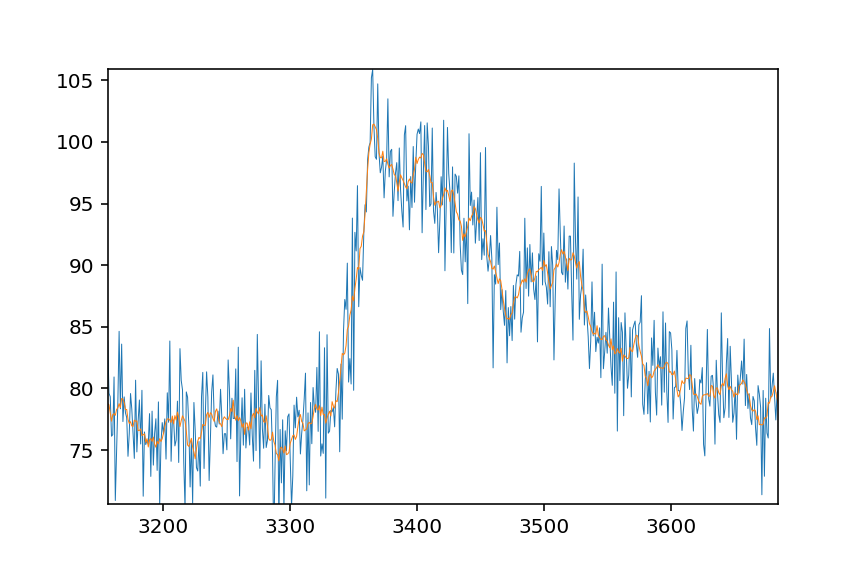

In [210]:
%matplotlib notebook
plt.plot(timeProfile,lw=.5)
t,x = profileAverages[10][["time","smooth"]].values.T
plt.plot(t,x,lw=.5)

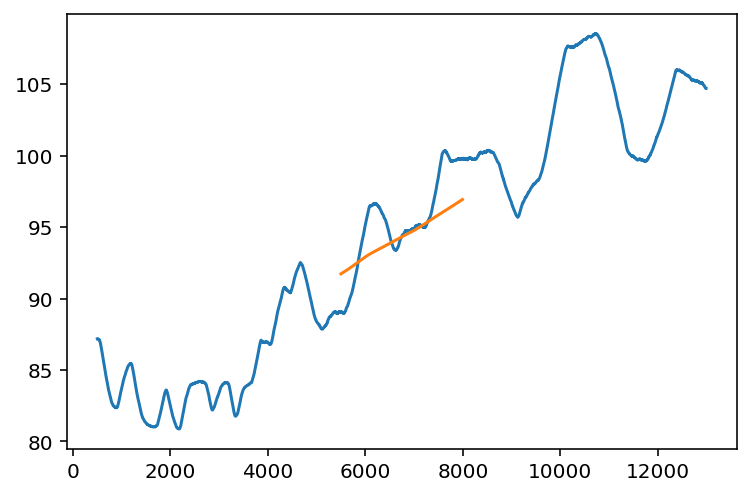

In [197]:

plt.plot(t,x)
n = 9999
plt.plot(
    moving_average(t,n),
    moving_average(x,n)
        )

In [194]:
t

array([  499.,   500.,   501., ..., 12988., 12989., 12990.])

In [193]:
moving_average(t,n)

array([  503.,   504.,   505., ..., 12984., 12985., 12986.])

In [189]:
t

0          499.0
1          500.0
2          501.0
3          502.0
4          503.0
          ...   
12487    12986.0
12488    12987.0
12489    12988.0
12490    12989.0
12491    12990.0
Name: time, Length: 12492, dtype: float64

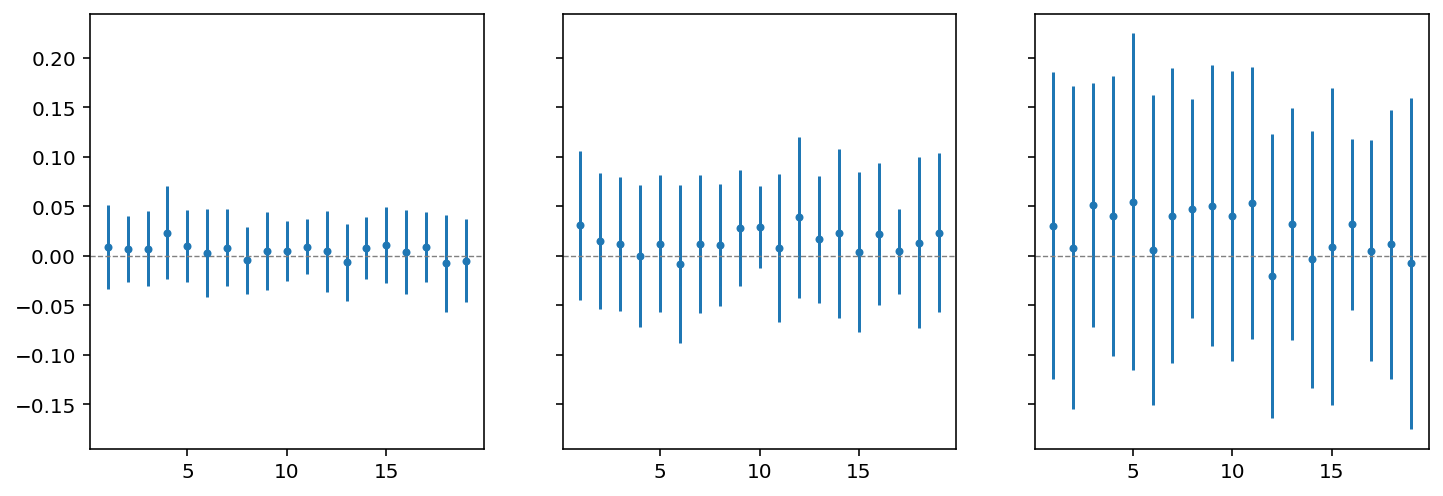

In [331]:
xr = np.arange(1,20)
dtBin = 3
nc = 3
fig, axs = plt.subplots(1,nc,figsize=(nc*4,4), sharex=True, sharey=True)
for i in range(nc):
    ax = axs.flat[i]
#     plt.subplot(1,nc,i+1)
    if i==0:
        X = timeProfile.copy()
    else:
        nTime = len(X)
        X = X[:nTime//dtBin*dtBin].reshape(nTime//dtBin,dtBin).mean(axis=1)
    yr, ye = autocorr(X, xr,nsplits=20)
    ax.errorbar(xr,yr,ye,ls="none",marker=".")
    ax.axhline(0,color='grey', ls="--", lw=.7)
#     plt.show()

(-13.190000000000001, 268.19)

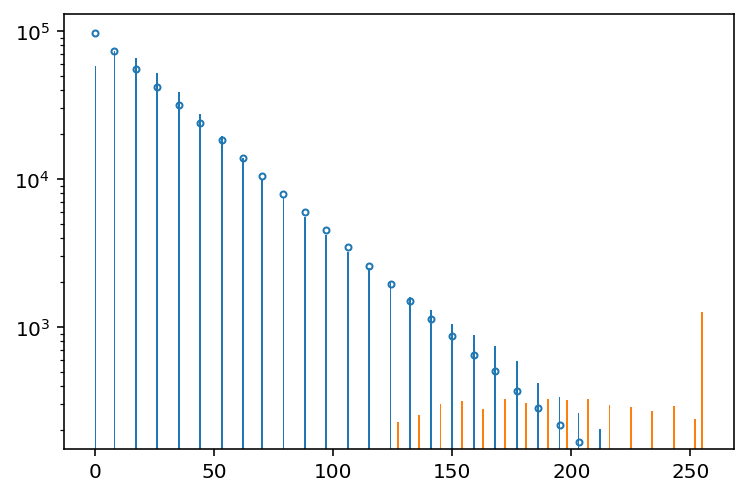

In [51]:


realxx = dst.expon.rvs(scale=3.6,size=(2,int(1e6)))
for xx in [
    (realxx.flatten()  .astype( int)*8.865).astype(int),
]:
    xr,yr = np.array(tally(xx)).T
    plt.plot(xr,yr/yr.sum()*y.sum(),".", mfc="none")

    
ims_r = ims[:,:,1:-1]
xr,yr = np.array(tally(ims_r[~np.isin(ims_r,xr)].flatten())).T


plt.bar(xr,yr)
# # plt.bar(xr,yr/yr.sum()*1,color="C2")

plt.xlim(xl)

<BarContainer object of 7 artists>

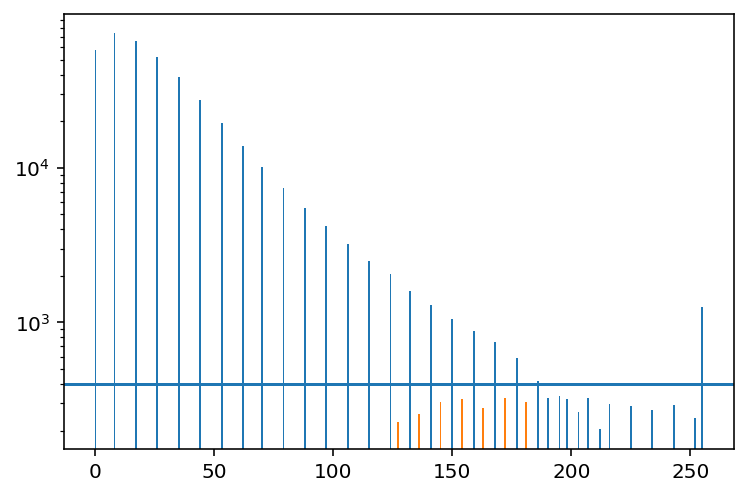

In [48]:
th = 4e2
plt.axhline(th)
take = x[y<th]
take = take[take<190]

tmp = tmp[np.isin(tmp,take)]
x,y = np.array(tally(tmp)).T
plt.bar(x,y)

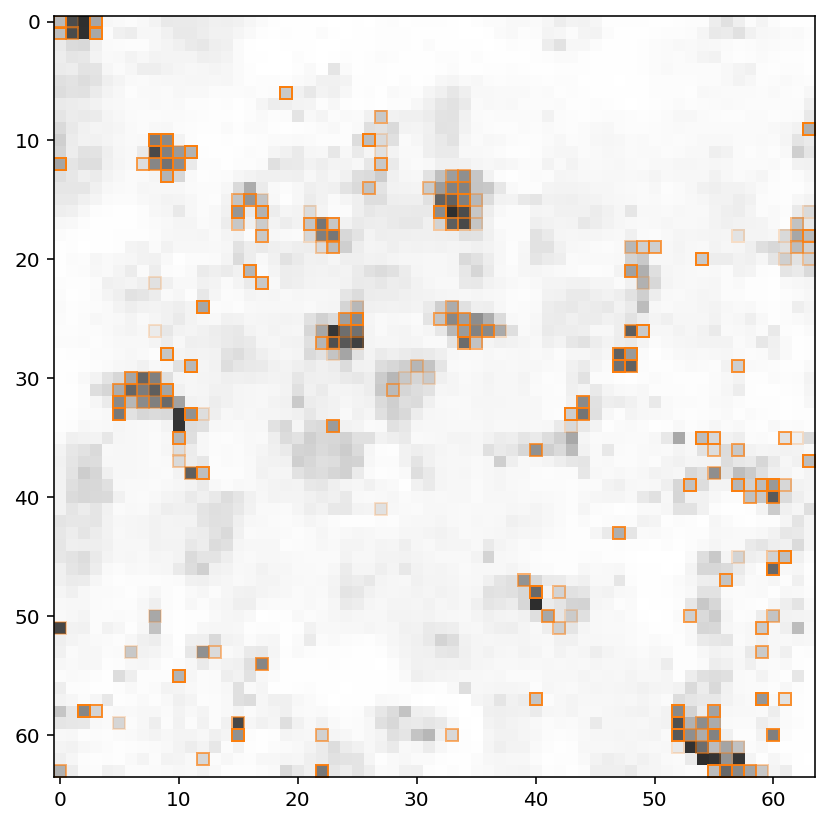

In [49]:
plt.figure(figsize=(7,7))
plt.imshow(np.mean(ims,axis=0).T, cmap="Greys",vmax=300)
for t,x,y in zip(*np.where(np.isin(ims,take))):
    plt.plot(x,y,"C1s",
             alpha = .2,
             mfc="none"
            )
    #, )#,mec="C1")

In [85]:
from scipy.stats import distributions as dst

(-13.190000000000001, 268.19)

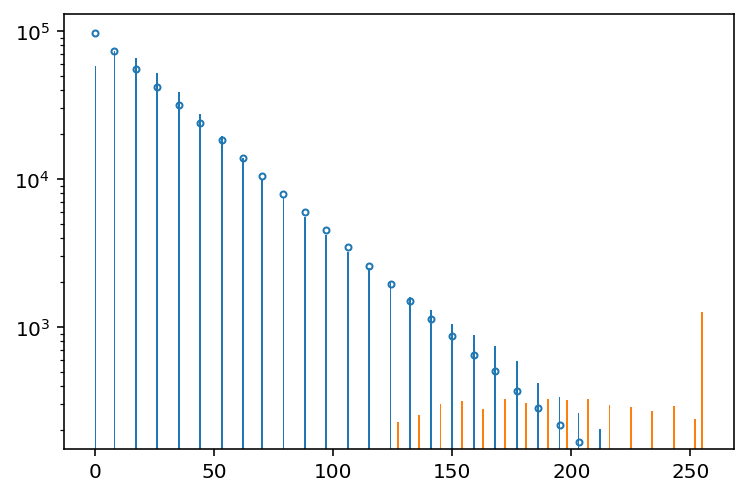

In [51]:
# x,y = np.array(tally(ims.flatten())).T
# plt.bar(x,y)

x,y = np.array(tally(ims.T[1:-1].flatten())).T
plt.bar(x,y)

plt.yscale("log")
xl = plt.xlim()

realxx = dst.expon.rvs(scale=3.6,size=(2,int(1e6)))
for xx in [
    (realxx.flatten()  .astype( int)*8.865).astype(int),
]:
    xr,yr = np.array(tally(xx)).T
    plt.plot(xr,yr/yr.sum()*y.sum(),".", mfc="none")

    
ims_r = ims[:,:,1:-1]
xr,yr = np.array(tally(ims_r[~np.isin(ims_r,xr)].flatten())).T


plt.bar(xr,yr)
# # plt.bar(xr,yr/yr.sum()*1,color="C2")

plt.xlim(xl)

In [52]:
take = xr

In [53]:
imsf = ims.astype(float)

In [54]:
imsf[~np.isin(imsf,take)] = np.nan

/Users/srdjan/anaconda2/envs/physio/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


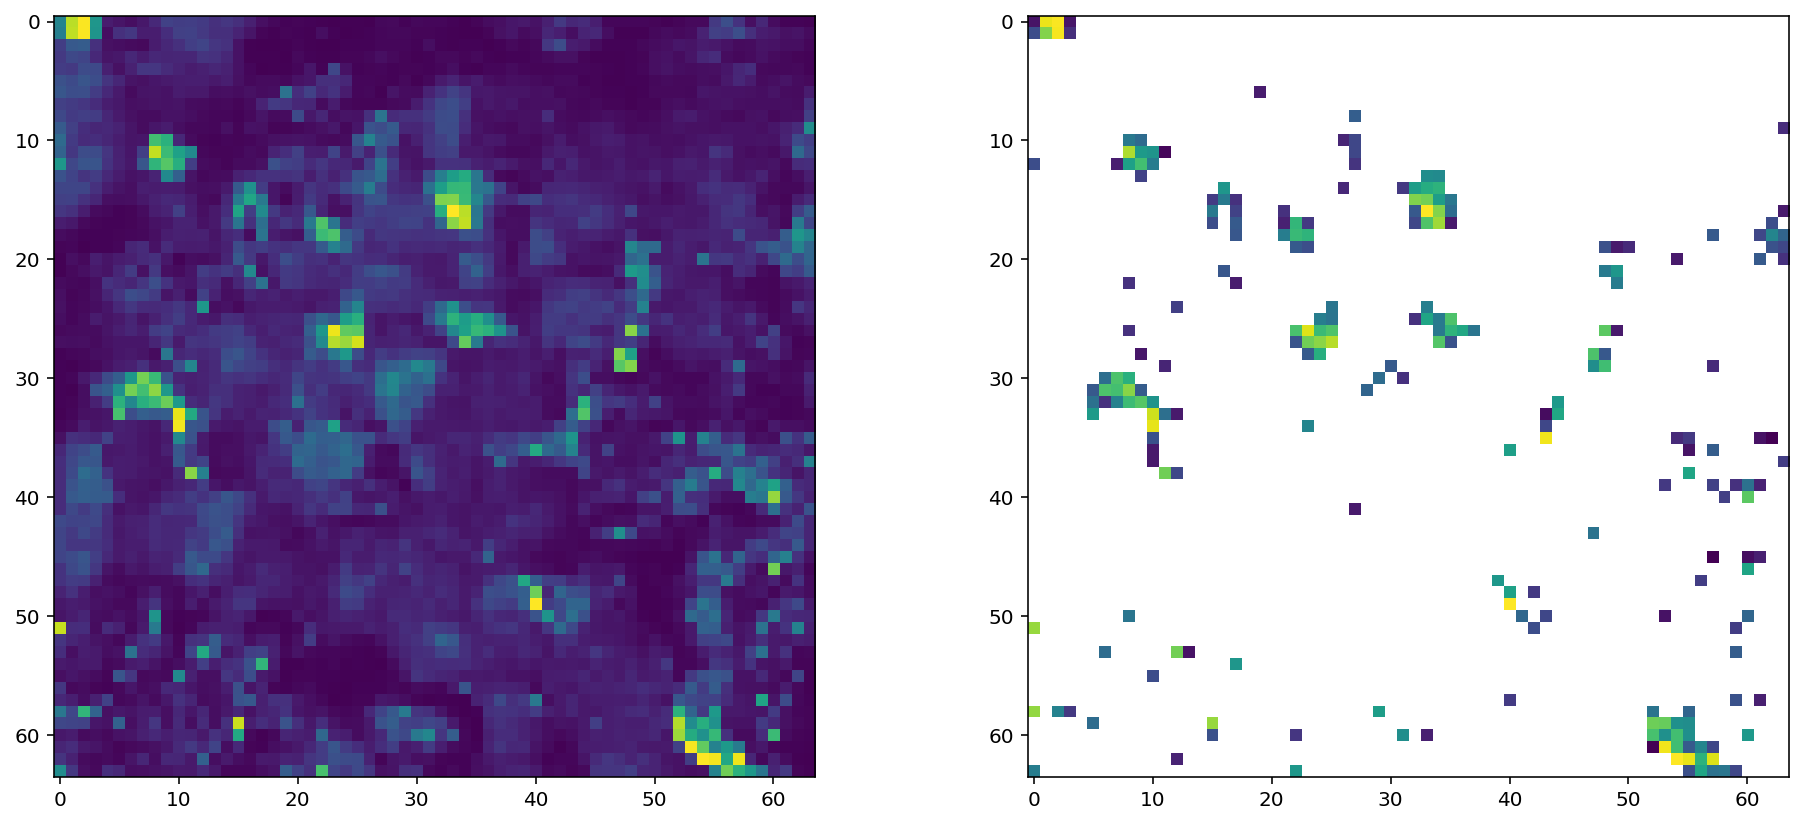

In [55]:
fig,axs = plt.subplots(1,2,figsize=(16,7))
axs[0].imshow(np.nanmean(ims ,axis=0).T)
axs[1].imshow(np.nanmean(imsf,axis=0).T)
# for t,x,y in zip(*np.where(np.isin(ims[::1000],take))):
#     plt.plot(x,y,"C1s",
#              alpha = .2,
#              mfc="none"
#             )
#     #, )#,mec="C1")

# Kill javabridge

In [ ]:
javabridge.kill_vm()